> Before running the notebook, please run the installation of these few packages

In [ ]:
!pip install scikit-plot
!pip install seaborn
!pip install xgboost
!pip install lightgbm
!pip install dask
!pip install dask-ml

# AI for S.E.A (Safety)

**Problem Statement:**<br>
Given the telematics data for each trip and the label if the trip is tagged as dangerous driving, derive a model that can detect driving trips.

The stages below were carried out in order to solve the problem

1. Ask question (we need to ask the right question that will help to solve the problem)
2. Understand data given
3. Analyze and explore the data
4. Generate and select features
6. Build model and solve the problem
7. Visualize and report the model's performance

Noted that these stages are just general sequence. However, there maybe use case with exceptions.
* We may combine multiple stages. We may generate features and analyze the features

## Ask question

Before starting to explore and experiment with the data, we need to ask few questions that can help to guide us in solving the problem. These are the few questions that I am curious and hope to solve at the end of the challenge.

1. What common features that exist in dangerous drivers?
2. What features that are most useful for the tree-based models to make prediction?
3. What features that are most useful for the linear-based models to make prediction?
4. Which model can perform best in capturing the information of these features and predict the dangerous driver accurately?
5. How can the model help to make better business decision? For example, should we be very strict about the prediction result of the model or we can tolerate with some mistakes in the prediction result?

In order to answer these questions, the first step that we need to do is to understand the data provided.

## Understand data given

For solving this problem, the dataset is provided with **data_dictionary.xlsx** that contains all the information about the features/columns that exist in this dataset.

* **bookingID**: trip id  
* **Accuracy**: accuracy inferred by GPS in meters
* **Bearing**: GPS bearing
* **acceleration_x**: accelerometer reading in x axis (m/s2)
* **acceleration_y**: accelerometer reading in y axis (m/s2)
* **acceleration_z**: accelerometer reading in z axis (m/s2)
* **gyro_x**: gyroscope reading in x axis (rad/s)
* **gyro_y**: gyroscope reading in y axis (rad/s)
* **gyro_z**: gyroscope reading in z axis (rad/s)
* **second**: time of the record by number of seconds
* **Speed**: speed measured in GPS in m/s

## Analyze and explore the data

Let's start to analyze the data provided and doing some exploration to see what can we find.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# get all the filename that contains training data and save into data_files
# save the filename that contains label into another variable
data_files = []
label_file = './data/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv'
for f in next(os.walk("./data/"))[2]:
    if f.endswith("csv") and f != label_file:
        data_files.append(f)

In [4]:
# read all the csv file in data_files and save into data list
_data = []
for file in data_files:
    df = pd.read_csv("./data/" + file)
    _data.append(df)
_data = pd.concat(_data)

In [5]:
# read the label_file and save into label variable
label = pd.read_csv(label_file)

In [6]:
_data.head()

,Accuracy,Bearing,Speed,acceleration_x,acceleration_y,acceleration_z,bookingID,gyro_x,gyro_y,gyro_z,label,second
0,10.000,66.600891,25.750000,0.903348,-9.662726,-3.650476,1520418422970,0.017363,0.049947,-0.007030,NaN,1221.0
1,14.000,115.000000,10.932214,-0.389816,8.700424,-0.613846,1047972020340,0.020203,-0.003387,-0.014130,NaN,9.0
2,4.000,74.000000,25.159718,-6.873963,0.852362,5.657671,1666447310862,-0.036326,0.046797,0.001703,NaN,675.0
3,3.663,261.000000,2.980912,-0.099359,9.641450,0.871489,420906795122,-0.001222,0.003665,-0.006109,NaN,21.0
4,10.000,49.842670,3.130000,0.441730,-8.066278,-5.572314,927712936057,-0.010548,0.020062,-0.022288,NaN,62.0


There are a lot of repeating bookingID, so what I guess is that one bookingID refers to one trip. It does not make sense to me that these repeating bookingID can be any helpful to the model and may cause problem like **overfitting**. So, instead of keeping all these repeating bookingID, I decide to group these row using bookingID and select the **mean, sum, max and min** value for each column. (Generate as much features as possible)

In [7]:
data = pd.DataFrame()
for col in _data.columns:
    if col != "bookingID" and col != "label":
        temp = _data.groupby("bookingID")[col].agg(["mean", "sum", "max", "min"])
        data[col + "_mean"] = temp["mean"]
        data[col + "_sum"] = temp["sum"]
        data[col + "_max"] = temp["max"]
        data[col + "_min"] = temp["min"]

In [8]:
len(data)

20000

Wah!! It greatly reduce the number of training data. Then, it should make the training of model relatively easy and **less resource demanding**

In [9]:
data = pd.merge(data, label, on="bookingID")

In [10]:
len(data)

20018

!!! Why suddenly got 18 more rows? Let's investigate first

In [11]:
data.bookingID.duplicated().head(15)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
Name: bookingID, dtype: bool

Looks like number **10** bookingID is repeated!! Why?? Is it maybe due to there are **2** labels that row?

In [12]:
data.loc[9:10]

,bookingID,Accuracy_mean,Accuracy_sum,Accuracy_max,Accuracy_min,Bearing_mean,Bearing_sum,Bearing_max,Bearing_min,Speed_mean,...,gyro_y_min,gyro_z_mean,gyro_z_sum,gyro_z_max,gyro_z_min,second_mean,second_sum,second_max,second_min,label
9,13,11.157522,13701.437,1251.564,3.0,212.998371,261562.0,359.0,0.0,15.521918,...,-0.396778,0.00538,6.607197,0.15878,-0.190635,634.483713,779146.0,1379.0,0.0,0
10,13,11.157522,13701.437,1251.564,3.0,212.998371,261562.0,359.0,0.0,15.521918,...,-0.396778,0.00538,6.607197,0.15878,-0.190635,634.483713,779146.0,1379.0,0.0,1


It looks like that's the case, let's just keep last row

In [13]:
data.drop_duplicates(subset="bookingID", keep="last", inplace=True)

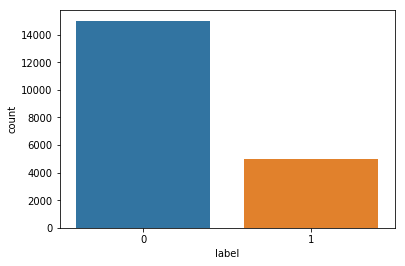

In [14]:
sns.countplot(data.label)

In [15]:
num_class_one = data.label.value_counts()[1] 
total_label_count = len(data.label)

# percentage of class 1 
print("Percentage of class 1 label: {:.2f}%".format((num_class_one / total_label_count) * 100))

Percentage of class 1 label: 24.95%


From the diagram above, we can observer that this is an **imbalanced class problem**. Only **24.95%** of the training data is labelled class 1. Thus, we need to evaluate our model using AUC-ROC score. Otherwise, we just predict all the label as class 0 and we will achieve a good result of **75.05%** of accuracy.

Clean the data a bit before moving to next step. Need to reset the index and remove the **bookingID** column.

In [16]:
data = data.drop(columns=["bookingID"]).reset_index(drop=True)

## Generate and Select features

before starting to create any new features, we need to reduce the variance of the data by eliminating any **outliers** exist. To find the outliers, we need to can use **violin plot** to inspect whether there is any outliers in the features.

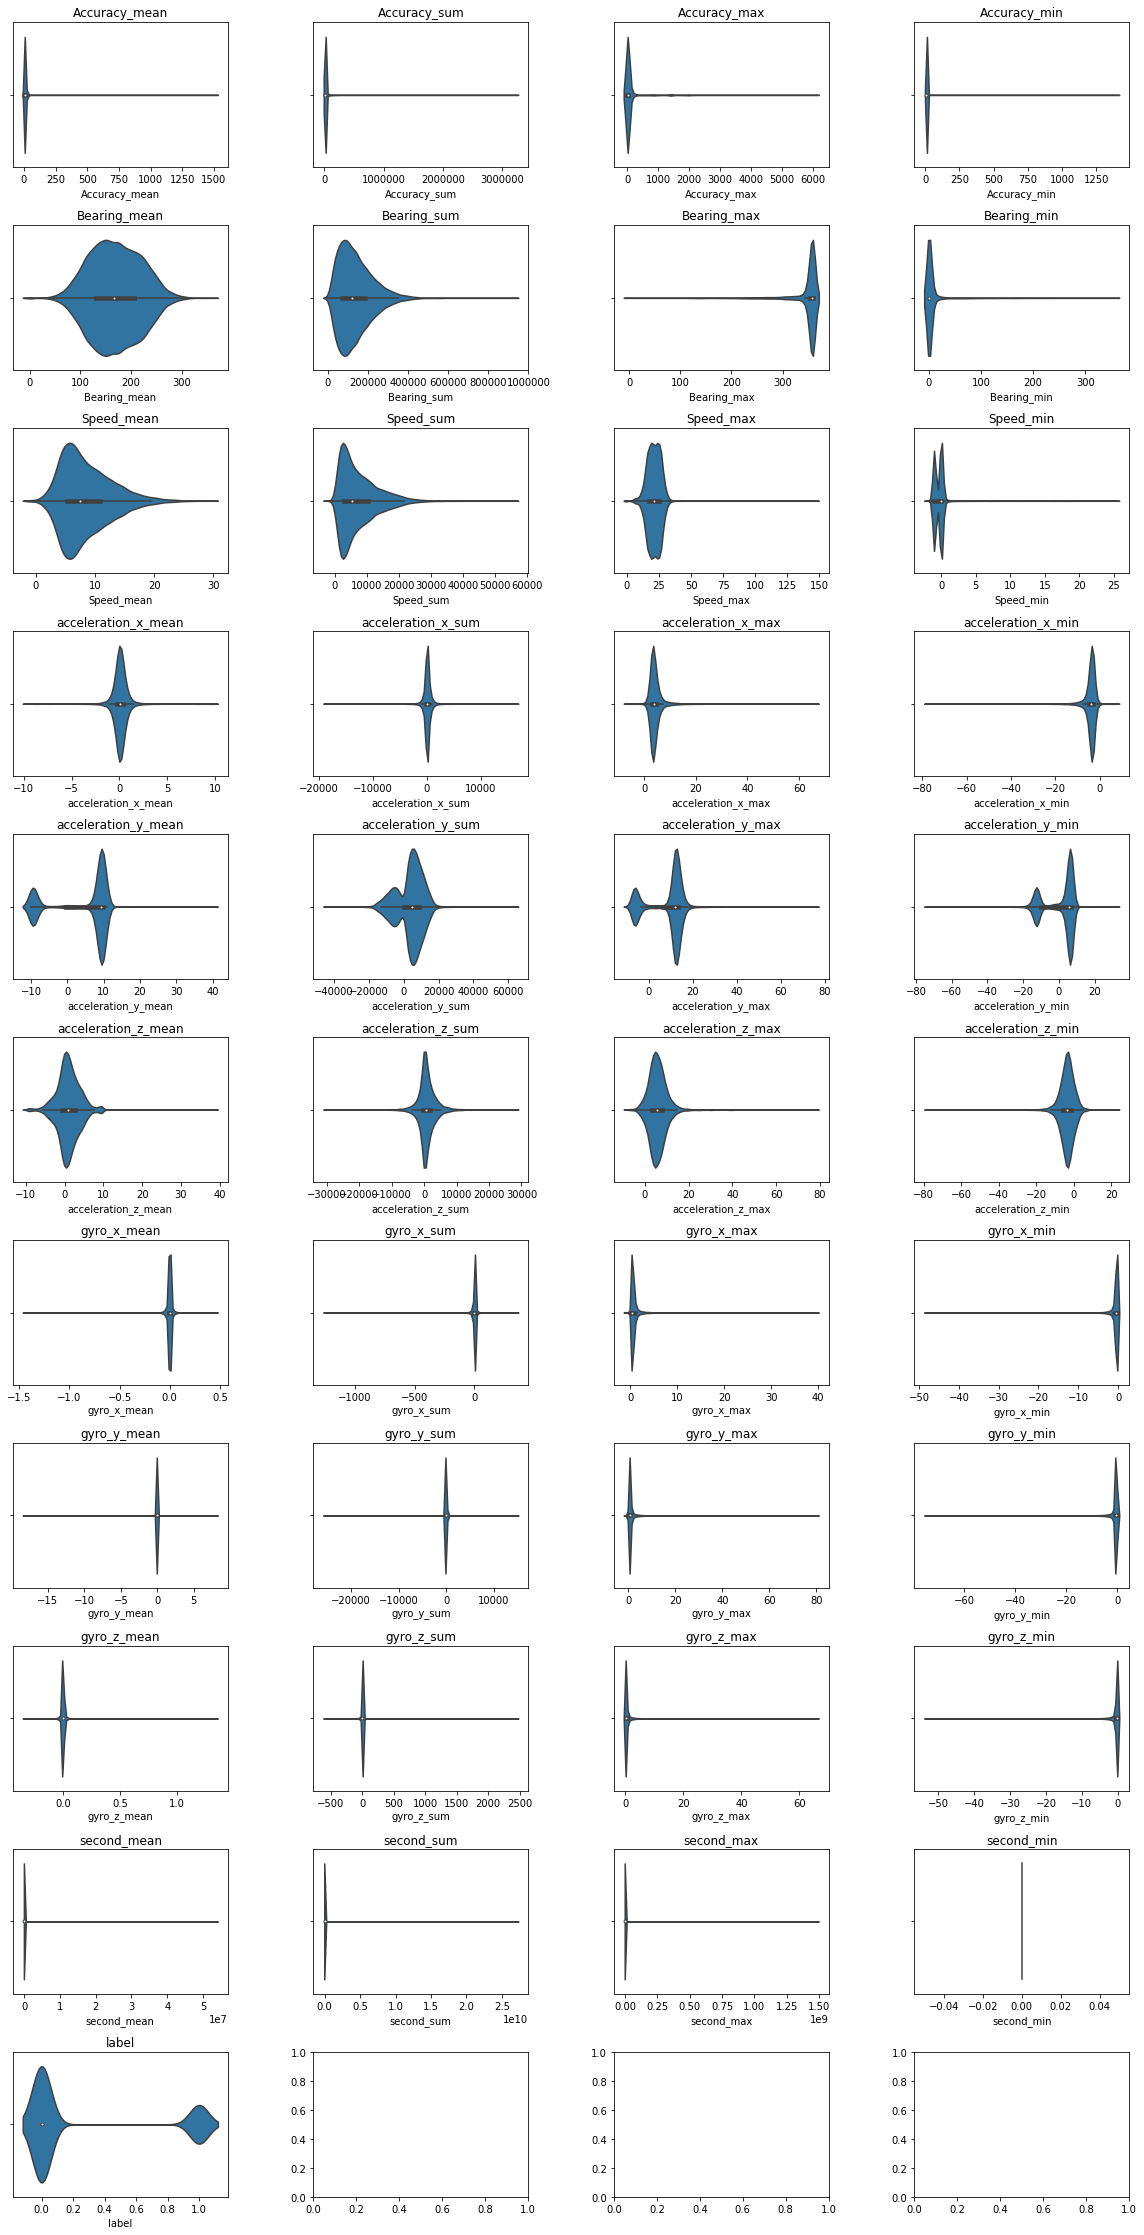

In [17]:
# this cell will take a bit of time (run with cautious)
fig, axes = plt.subplots(11, 4)
fig.set_figheight(40)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(data.columns)):
    row = i // 4
    column = i % 4
    sns.violinplot(data[data.columns[i]], ax=axes[row, column]).set_title("{}".format(data.columns[i]))

look like **second_min** is just **0**. Should remove this feature now

In [18]:
data.drop(columns=["second_min"], inplace=True)

By looking at the diagram above, we can clearly see that these most of the features are having extreme values. Thus, there must be outliers exist and these outliers will make it difficult for us to understand our model's performance.

To handle the outliers, refer to this blog post (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/).

For this case, we will just focus on **second** feature because it will be used later to generate more features. So we don't want this feature too extreme. In order to eliminate the outliers, we choose to use **standard deviation method** to eliminate the outliers specifically, **2 standard deviation from mean** which will retains **95%** of the data left.

In [19]:
def calculate_std_upper_lower(data_series, std_multiplier=2):
    """
    Parameters
    ----------------------
    data_series : pandas.core.series.Series
        The data series that need to calculate the lower and upper bound
    std_multiplier : int
        The value that need to multiply the standard deviation
    
    Returns
    ----------------------
    tuple
        a tuple contains lower and upper bound of the data_series
    """
    mean, std = data_series.mean(), data_series.std()
    cut_off = std * std_multiplier
    lower, upper = mean - cut_off, mean + cut_off
    return (lower, upper)

In [20]:
# acc_lower, acc_upper = calculate_std_upper_lower(data.Accuracy)
# bear_lower, bear_upper = calculate_std_upper_lower(data.Bearing)
# acc_x_lower, acc_x_upper = calculate_std_upper_lower(data.acceleration_x)
# acc_y_lower, acc_y_upper = calculate_std_upper_lower(data.acceleration_y)
# acc_z_lower, acc_z_upper = calculate_std_upper_lower(data.acceleration_z)
# gyro_x_lower, gyro_x_upper = calculate_std_upper_lower(data.gyro_x)
# gyro_y_lower, gyro_y_upper = calculate_std_upper_lower(data.gyro_y)
# gyro_z_lower, gyro_z_upper = calculate_std_upper_lower(data.gyro_z)
sec_mean_lower, sec_mean_upper = calculate_std_upper_lower(data.second_mean)
sec_sum_lower, sec_sum_upper = calculate_std_upper_lower(data.second_sum)
sec_max_lower, sec_max_upper = calculate_std_upper_lower(data.second_max)
# sec_min_lower, sec_min_upper = calculate_std_upper_lower(data.second_min)
# speed_lower, speed_upper = calculate_std_upper_lower(data.Speed)

In [21]:
# data = data.loc[(data.Accuracy > acc_lower) & (data.Accuracy < acc_upper)]
# data = data.loc[(data.Bearing > bear_lower) & (data.Bearing < bear_upper)]
# data = data.loc[(data.acceleration_x > acc_x_lower) & (data.acceleration_x < acc_x_upper)]
# data = data.loc[(data.acceleration_y > acc_y_lower) & (data.acceleration_y < acc_y_upper)]
# data = data.loc[(data.acceleration_z > acc_z_lower) & (data.acceleration_z < acc_z_upper)]
# data = data.loc[(data.gyro_x > gyro_x_lower) & (data.gyro_x < gyro_x_upper)]
# data = data.loc[(data.gyro_y > gyro_y_lower) & (data.gyro_y < gyro_y_upper)]
# data = data.loc[(data.gyro_z > gyro_z_lower) & (data.gyro_z < gyro_z_upper)]
data = data.loc[(data.second_mean > sec_mean_lower) & (data.second_mean < sec_mean_upper)]
data = data.loc[(data.second_sum > sec_sum_lower) & (data.second_sum < sec_sum_upper)]
data = data.loc[(data.second_max > sec_max_lower) & (data.second_max < sec_max_upper)]
# data = data.loc[(data.second_min > sec_min_lower) & (data.second_min < sec_min_upper)]
# data = data.loc[(data.Speed > speed_lower) & (data.Speed < speed_upper)]

Since a lot of features such as **Speed**, **acceleration_(x/y/z)** and **gyro_(x/y/z)** are all divide by the time, it make sense for me to multiply these features with **second** to get **distance**, **velocity** and **angle** back. 

In [22]:
# generate distance, velocity and angle features
for col in data.columns:
    if col.startswith("second"):
        agg_method = col.split("_")[1]
        data["distance_" + agg_method] = data[col] * data["Speed_" + agg_method]
        data["velocity_x_" + agg_method] = data[col] * data["acceleration_x_" + agg_method]
        data["velocity_y_" + agg_method] = data[col] * data["acceleration_y_" + agg_method]
        data["velocity_z_" + agg_method] = data[col] * data["acceleration_z_" + agg_method]
        data["angle_x_" + agg_method] = data[col] * data["gyro_x_" + agg_method]
        data["angle_y_" + agg_method] = data[col] * data["gyro_y_" + agg_method]
        data["angle_z_" + agg_method] = data[col] * data["gyro_z_" + agg_method]

In [23]:
len(data.columns) - 1 # minus 1 because there is one column is label

60

Now, we have **60** features that can be experimented and understand which features can perform well in separating the *safe* and *dangerous* driving trips

### Manual Select Feature

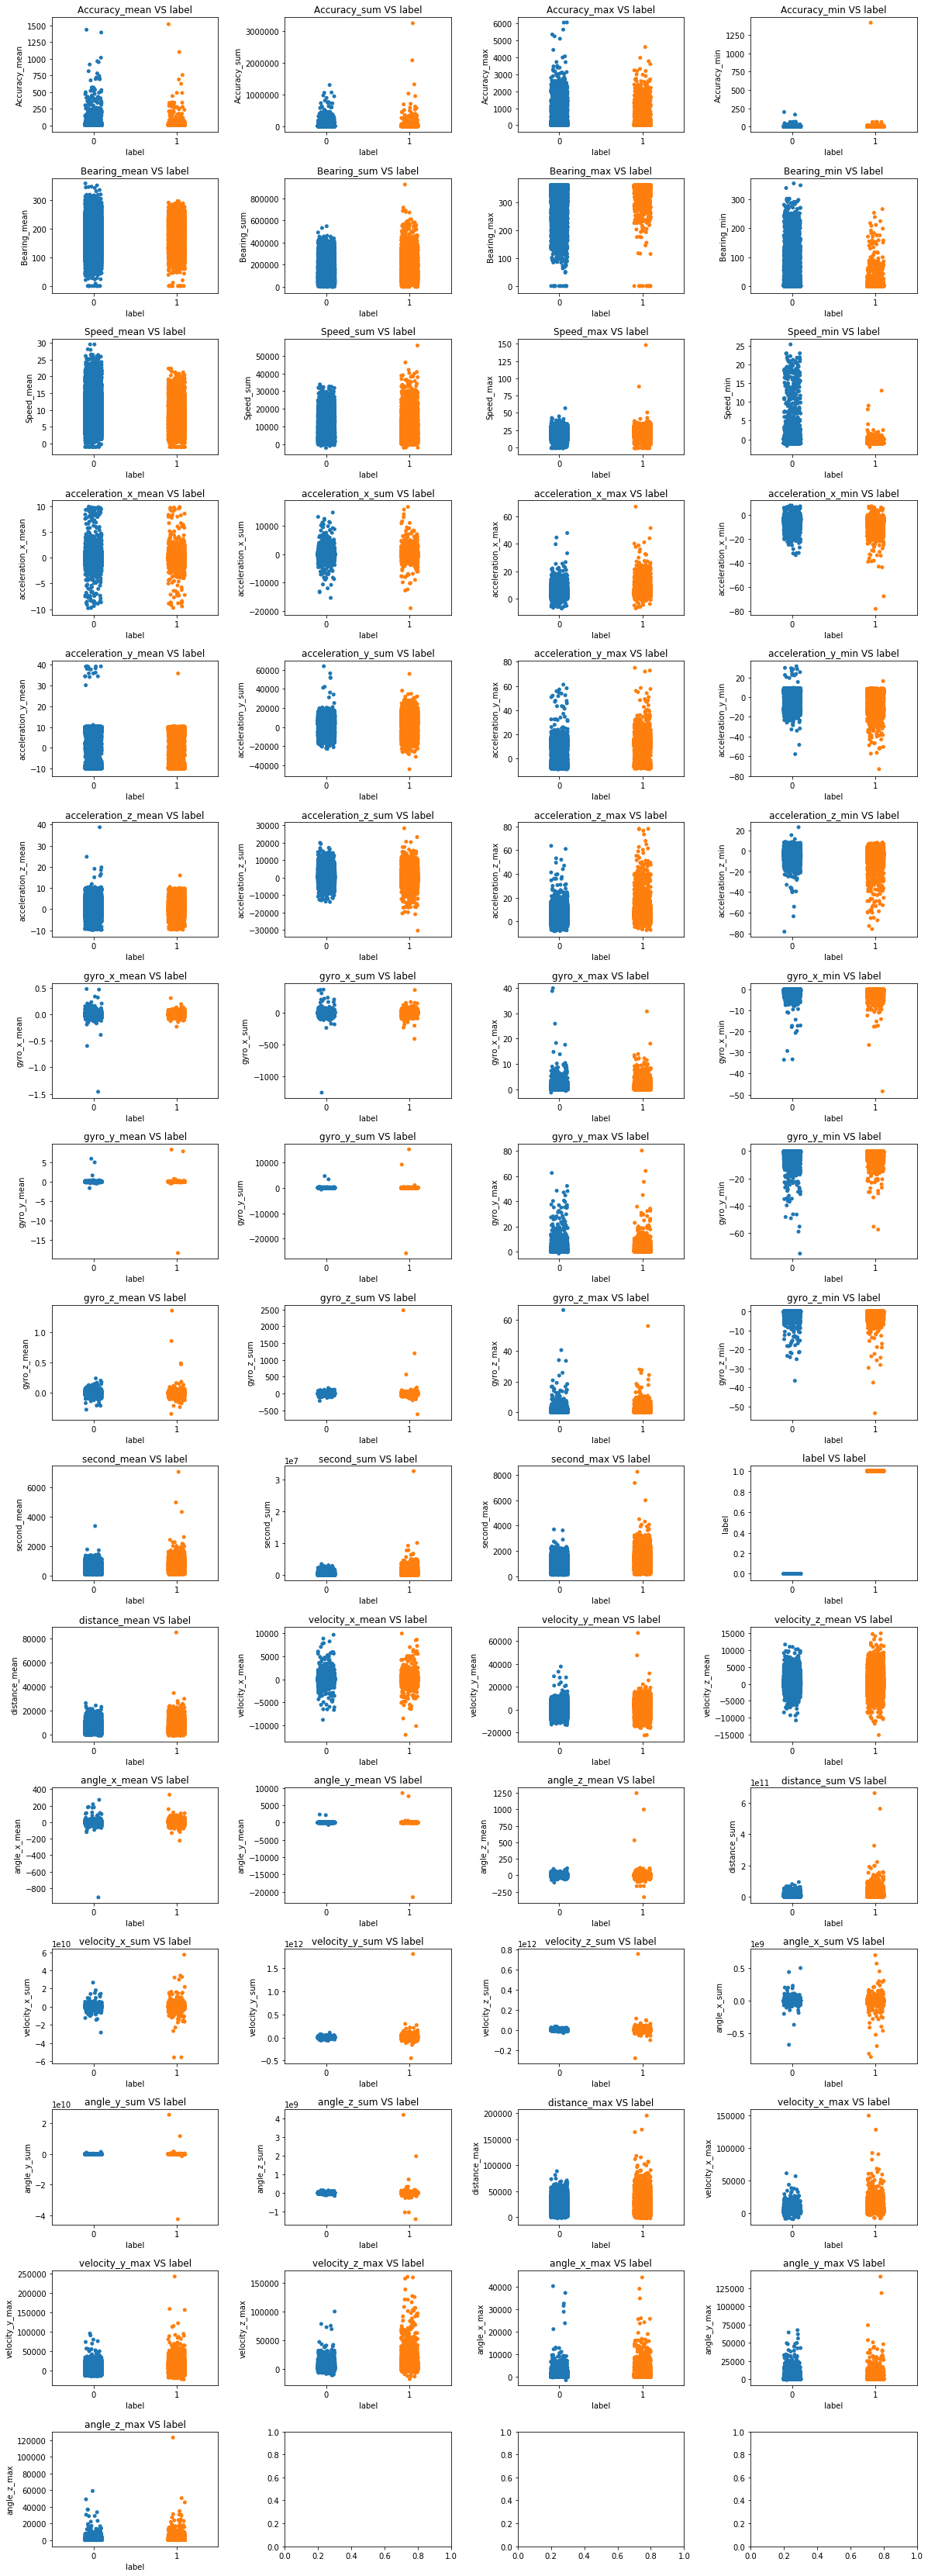

In [24]:
fig, axes = plt.subplots(16, 4)
fig.set_figheight(60)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(data.columns)):
    row = i // 4
    column = i % 4
    sns.stripplot(x="label", y=data.columns[i], data=data, ax=axes[row, column]).set_title("{} VS label".format(data.columns[i]))

From the diagram above, the features that look most promising are **Accuracy_mean**, **Bearing_min**, **acceleration_y_max**, **velocity_z_max**, **gyro_y_max** and **Speed_min**. Although **acceleration_z_max** also looks promising, but since it have high correlation with **velocity_z_max**, thus we only select **velocity_z_max**. The reason why these features are chosen is because that if we look at **Accuracy_mean**, if we cut the value at *200*, we can clearly see that *number of class 0 > number of class 1*.

With this insight, we are able to answer the first question which is 
1. What common features that exist in dangerous drivers?<br>
Answer: **Accuracy_mean**, **Bearing_min**, **acceleration_y_max**, **velocity_z_max**, **gyro_y_max** and **Speed_min**

The next thing that we can do to choose the features that will be used is through getting the feature importance of different models and use these features as guidelines to help us in **feature selection** step.

In [25]:
manual_selected_features = ["Accuracy_mean", "Bearing_min", "acceleration_y_max", "velocity_z_max", "gyro_y_max", "Speed_min"]

### Tree-based model Select Feature

In [26]:
from operator import itemgetter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor, LinearRegression, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [27]:
X = data.drop(columns=["label"]).reset_index(drop=True)
y = data.label.reset_index(drop=True)

In [28]:
tree_based_models = {
    "dt": DecisionTreeRegressor(),
    "rf": RandomForestRegressor(),
    "ada": AdaBoostRegressor(),
    "gb": GradientBoostingRegressor(),
    "et": ExtraTreesRegressor(),
    "xgb": XGBRegressor(),
    "lgb": LGBMRegressor()
}

In [29]:
# train all the models at once
for _, clf in tree_based_models.items():
    clf.fit(X, y)

In [30]:
def generate_sorted_feature_importance(columns_name, feature_importances):
    feature_importance_map = {}
    for i in range(len(columns_name)):
        feature_importance_map[columns_name[i]] = feature_importances[i]
    sorted_feature_importance = dict(sorted(feature_importance_map.items(), key=itemgetter(1)))
    return sorted_feature_importance

def plot_feature_importance(sorted_feature_importance, ax, title):
    num_feature = 20
    bp = sns.barplot(list(sorted_feature_importance.keys())[-num_feature:], list(sorted_feature_importance.values())[-num_feature:], ax=ax)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    bp.set_title(title)
    return bp

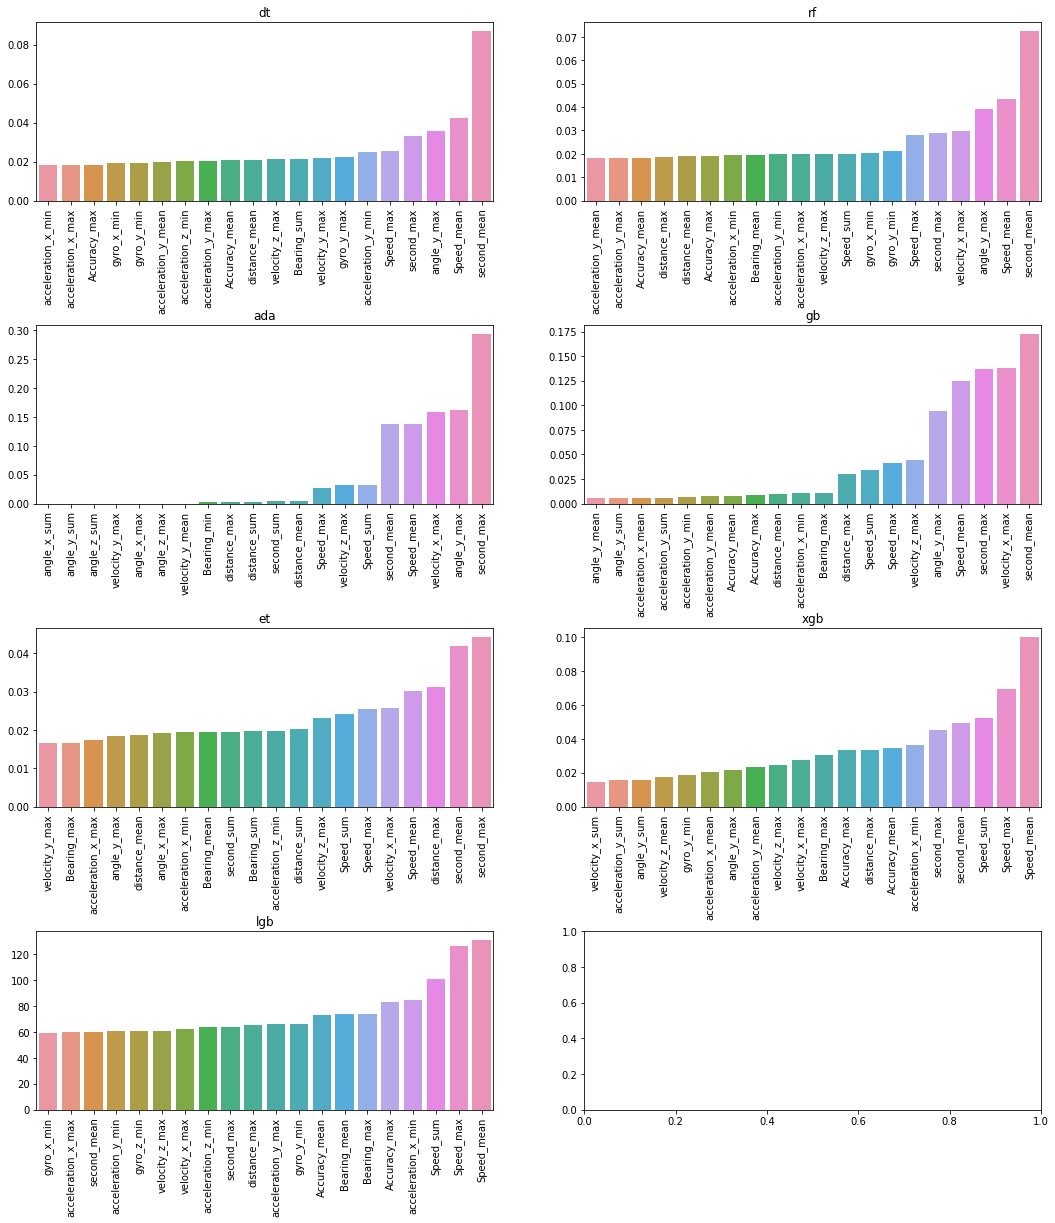

In [31]:
# to visualize the 20 most important features of each tree-based models
fig, axes = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.7)
count = 0
for name, clf in tree_based_models.items():
    row = count // 2
    column = count % 2
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    plot_feature_importance(sorted_feature_importance, axes[row, column], name)
    count += 1

In [32]:
# create feature importance table. Easy to navigate and explore
clf_features_importance = pd.DataFrame()
for name, clf in tree_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [33]:
# select the top 10 features of each model
clf_features_importance[-10:]

,dt,rf,ada,gb,et,xgb,lgb
50,velocity_z_max,velocity_z_max,second_sum,Bearing_max,acceleration_z_min,Bearing_max,acceleration_y_max
51,Bearing_sum,Speed_sum,distance_mean,distance_max,distance_sum,Accuracy_max,gyro_y_min
52,velocity_y_max,gyro_x_min,Speed_max,Speed_sum,velocity_z_max,distance_max,Accuracy_mean
53,gyro_y_max,gyro_y_min,velocity_z_max,Speed_max,Speed_sum,Accuracy_mean,Bearing_mean
54,acceleration_y_min,Speed_max,Speed_sum,velocity_z_max,Speed_max,acceleration_x_min,Bearing_max
55,Speed_max,second_max,second_mean,angle_y_max,velocity_x_max,second_max,Accuracy_max
56,second_max,velocity_x_max,Speed_mean,Speed_mean,Speed_mean,second_mean,acceleration_x_min
57,angle_y_max,angle_y_max,velocity_x_max,second_max,distance_max,Speed_sum,Speed_sum
58,Speed_mean,Speed_mean,angle_y_max,velocity_x_max,second_mean,Speed_max,Speed_max
59,second_mean,second_mean,second_max,second_mean,second_max,Speed_mean,Speed_mean


The next thing we need to do is to decide the number of features that need to be selected in order to train the tree-based models. In order to select the features, we need a threshold to make the decision. This is because until a certain number of features, the score will not improve any more. So, we will use **GradientBoostingRegressor** to help us in deciding the threshold.

In [34]:
# run with cautious (this may take a long time)
tree_sc = []
tree_iterations = list(range(5, 61))
for i in tree_iterations:
    tree_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 7]
    clf = GradientBoostingRegressor()
    score = np.mean(cross_val_score(clf, X.loc[:, tree_model_selected_features], y, cv=5, scoring="roc_auc"))
    tree_sc.append(score)

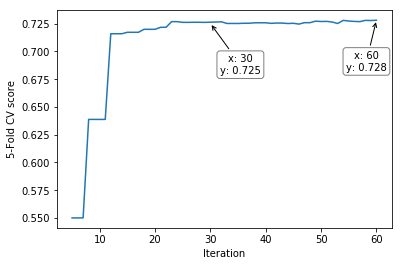

In [35]:
fig, axes = plt.subplots()
sns.lineplot(tree_iterations, tree_sc, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = tree_iterations[tree_sc.index(max(tree_sc))]
max_y_loc = max(tree_sc)
axes.annotate(
    "x: {}\ny: {:.3f}".format(30, tree_sc[30]), xy=(30, tree_sc[30]), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(30, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
axes.annotate(
    "x: {}\ny: {:.3f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(-10, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

From the diagram, it can be seen that the roc-auc score keeps on rising rapidly until certain threshold. After that, the score is improving but only slightly. The point which have the maximum value of threshold is always large. Thus, we choose the threshold to be the middle number of the features which is **30**.

In [36]:
tree_model_selected_features = [key for key, val in clf_features_importance[-30:].stack().value_counts().items() if val == 7]

In [37]:
tree_model_selected_features

['Speed_sum',
 'second_max',
 'distance_max',
 'gyro_z_max',
 'second_mean',
 'Speed_max',
 'angle_y_max',
 'velocity_z_max',
 'velocity_x_max',
 'Speed_mean']

By completing this step, we are now able to answer the second question. 

2. What features that are most useful for the tree-based models to make prediction?<br>
Answer: refer to the list above

### Linear-based model Select Feature

In [38]:
linear_based_models = {
    "en": ElasticNet(),
    "hr": HuberRegressor(),
    "lr": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "sgd": SGDRegressor(), 
    "pa": PassiveAggressiveRegressor()
}

In [39]:
# train all the models at once
for _, clf in linear_based_models.items():
    clf.fit(X, y)

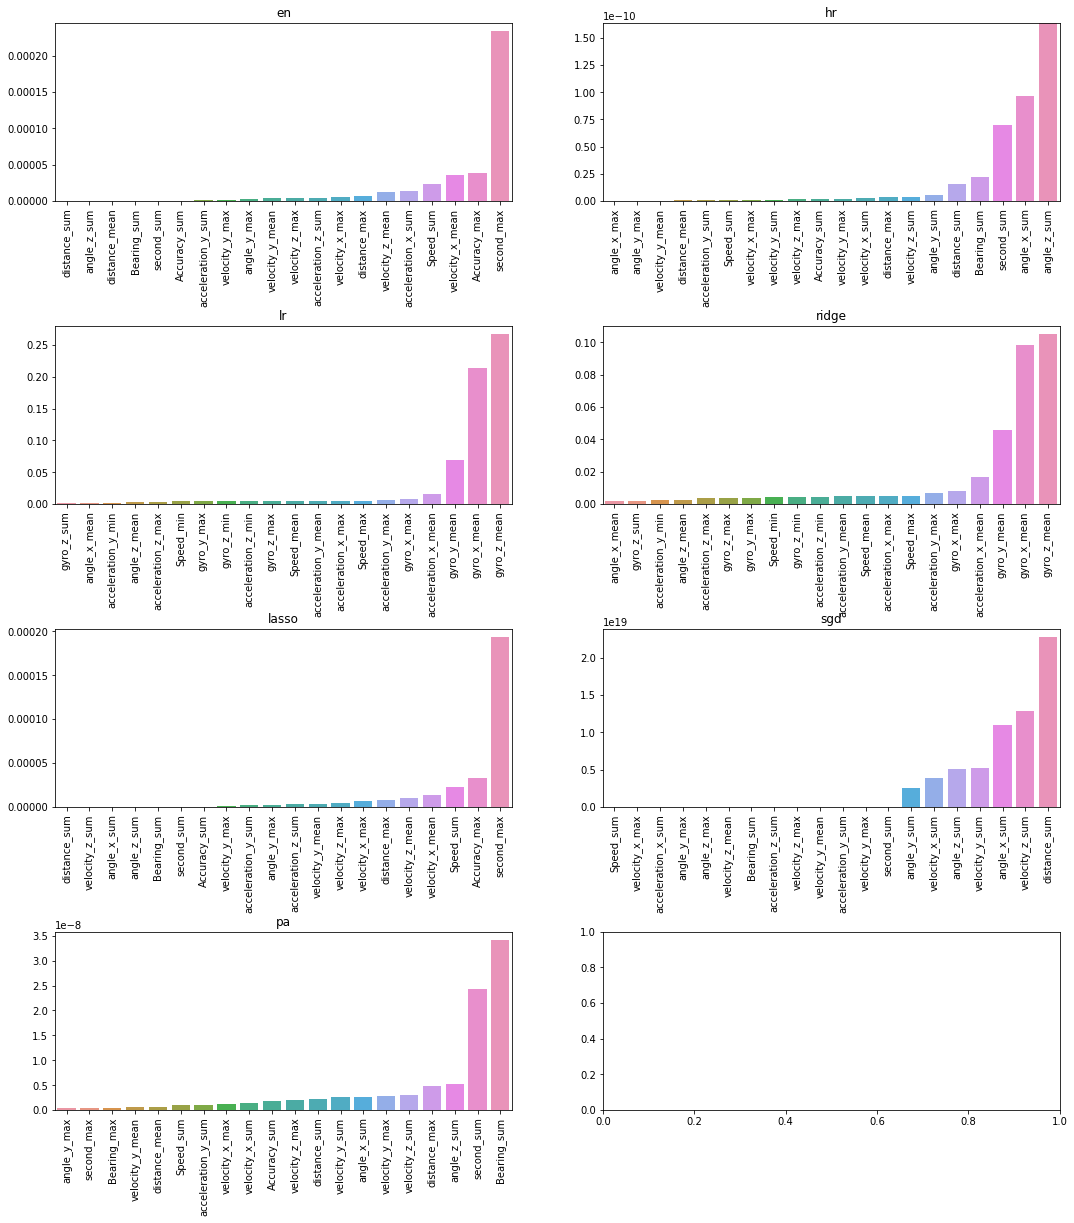

In [40]:
# to visualize the 20 most important features of each linear-based models
fig, axes = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.7)
count = 0
for name, clf in linear_based_models.items():
    row = count // 2
    column = count % 2
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, np.abs(clf.coef_)) # noted here we use the absolute value of coefficient
    plot_feature_importance(sorted_feature_importance, axes[row, column], name)
    count += 1

In [41]:
clf_features_importance = pd.DataFrame()
for name, clf in linear_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, np.abs(clf.coef_))
    clf_features_importance[name] = list(sorted_feature_importance.keys())

Similar with the tree-based model, we also need a threshold to decide how much features that we will need to select for linear-based model. In this example, we will be using **LinearRegression** to help us in making decision of the threshold.

In [42]:
linear_sc = []
linear_iteration = list(range(30, 61))
for i in linear_iteration:
    linear_model_selected_features = [key for key, val in clf_features_importance[-i:].stack().value_counts().items() if val == 7]
    clf = LinearRegression()
    score = np.mean(cross_val_score(clf, X.loc[:, linear_model_selected_features], y, cv=5, scoring="roc_auc"))
    linear_sc.append(score)

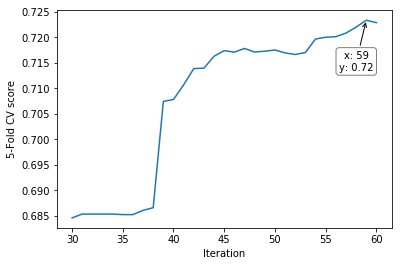

In [43]:
fig, axes = plt.subplots()
sns.lineplot(linear_iteration, linear_sc, ax=axes)
axes.set_xlabel("Iteration")
axes.set_ylabel("5-Fold CV score")
max_x_loc = linear_iteration[linear_sc.index(max(linear_sc))]
max_y_loc = max(linear_sc)
axes.annotate(
    "x: {}\ny: {:.2f}".format(max_x_loc, max_y_loc), xy=(max_x_loc, max_y_loc), xycoords="data", 
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    xytext=(-10, -50), textcoords="offset points", ha="center", arrowprops=dict(arrowstyle="->")
)
plt.show()

In the diagram above, we can observe that the roc-auc score will reach a maximum value when threshold equal to **59**. Thus, this point is suitable to use as the threshold to select the features for linear-based models.

In [44]:
linear_model_selected_features = [key for key, val in clf_features_importance[-max_x_loc:].stack().value_counts().items() if val == 7]

In [45]:
linear_model_selected_features

['velocity_x_sum',
 'acceleration_x_max',
 'acceleration_y_sum',
 'angle_z_mean',
 'gyro_y_max',
 'gyro_x_min',
 'angle_y_sum',
 'angle_z_max',
 'Bearing_min',
 'Accuracy_sum',
 'angle_y_max',
 'velocity_x_mean',
 'gyro_y_sum',
 'distance_sum',
 'angle_x_max',
 'gyro_x_max',
 'distance_mean',
 'Speed_sum',
 'second_sum',
 'gyro_x_sum',
 'acceleration_y_mean',
 'second_max',
 'velocity_y_max',
 'Bearing_max',
 'acceleration_y_min',
 'gyro_x_mean',
 'velocity_z_sum',
 'distance_max',
 'Speed_min',
 'acceleration_x_mean',
 'gyro_z_max',
 'acceleration_z_min',
 'acceleration_x_min',
 'Bearing_sum',
 'acceleration_z_mean',
 'gyro_z_min',
 'Bearing_mean',
 'acceleration_z_sum',
 'velocity_y_mean',
 'angle_x_sum',
 'Accuracy_min',
 'Accuracy_max',
 'velocity_z_max',
 'angle_y_mean',
 'Speed_mean',
 'acceleration_y_max',
 'acceleration_x_sum',
 'Speed_max',
 'angle_x_mean',
 'gyro_y_min',
 'gyro_z_sum',
 'velocity_x_max',
 'angle_z_sum',
 'velocity_z_mean',
 'second_mean',
 'acceleration_z_max


> complete this before submission

By completing this step, we are now able to answer the third question. 

3. What features that are most useful for the linear-based models to make prediction?<br>
Answer: Refer to the list above (too long to write it down)

Until now, we have generated 3 set of features which are **manual_selected_features**, **tree_model_selected_features** and **linear_model_selected_features**. With these features, we have done the **Feature Engineering** and **Feature Selection** steps.

Next, we need to start using the features generated to start building model.

## Build model and solve the problem

In [46]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingRegressor

# add parallel functionality to the training of model
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from dask_ml.model_selection import GridSearchCV

/home/eric/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Before starting to train any model, we need to define a validation strategy. In this case, we will be using **5-Fold Cross-Validation with ROC-AUC score**

In [47]:
# from imblearn.over_sampling import SMOTE

Is it neccessary for us to upsampling or downsampling our data? I had tried to upsample the data. However, it did not improve the result of the predictions. Meanwhile, it is also general to have **more safe driving trips** than **dangerous driving trips**. So, I decided not to resample the data. In this way, we will be more confident to say that the driving trips that predicted to be *dangerous* are really *dangerous*

In [48]:
client = Client()
kf = StratifiedKFold(n_splits=5, random_state=99)
# smote = SMOTE(random_state=99)

def get_cv_score(clf, X, y, kf):
    cv_scores = []
    with parallel_backend("dask"):
        for _, (train_index, test_index) in enumerate(kf.split(X, y)):
            train_X, train_y = X.loc[train_index], y[train_index] 
            # up sampling the train data
#             train_X, train_y = smote.fit_sample(train_X, train_y)
            test_X, test_y = X.loc[test_index], y[test_index]

            clf.fit(train_X, train_y)
            y_pred = clf.predict(test_X)
            score = roc_auc_score(test_y, y_pred)
            cv_scores.append(score)
        return np.mean(cv_scores)

Let's get the CV scores for tree-based and linear-based models in predicting the safeness of the driving trips

In [49]:
# perform 5-fold cross-validation of each model and return the mean value of the scores (tree-based models)
tree_cv_scores = []
for _, clf in tree_based_models.items():
    cv_score = get_cv_score(clf, X.loc[:, tree_model_selected_features], y, kf)
    tree_cv_scores.append(cv_score)

In [50]:
pd.DataFrame({"classifiers": list(tree_based_models.keys()), "CV score": tree_cv_scores}).sort_values("CV score")

,classifiers,CV score
0,dt,0.574134
4,et,0.669771
1,rf,0.670894
2,ada,0.700871
6,lgb,0.718084
3,gb,0.725580
5,xgb,0.725838


In [51]:
# perform 5-fold cross-validation of each model and return the mean value of the scores (linear-based models)
linear_cv_scores = []
for _, clf in linear_based_models.items():
    cv_score = get_cv_score(clf, X.loc[:, linear_model_selected_features], y, kf)
    linear_cv_scores.append(cv_score)

In [52]:
pd.DataFrame({"classifiers": list(linear_based_models.keys()), "CV score": linear_cv_scores}).sort_values("CV score")

,classifiers,CV score
5,sgd,0.457165
6,pa,0.552894
1,hr,0.618242
0,en,0.723332
4,lasso,0.723554
2,lr,0.723732
3,ridge,0.723785


By looking at both tables above, we are able to answer and fourth question asked.

4. Which models can perform best in capturing the information of these features and predict the safeness of the driving trip correctly?<br>
Answer: 
    * Tree-based models
        * **GradientBoostingRegressor**
        * **XGBRegressor**
    * Linear-based models
        * **Ridge**
        * **LinearRegression**
    
So, what we can do next is to **tune hyperparameters** or ensemble the model using **stacking** techniques.

### Tune GradientBoostingRegressor (This section took very long time
refer to the post here: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [55]:
gb_result = {}
gb_result["learning_rate"] = {"parameter": np.arange(0.01, 0.20, 0.05), "train_result": [], "test_result": []}
gb_result["n_estimators"] = {"parameter": np.arange(30, 200, 20), "train_result": [], "test_result": []}
gb_result["max_depth"] = {"parameter": np.linspace(3, 20, 10), "train_result": [], "test_result": []}
gb_result["min_samples_split"] = {"parameter": np.linspace(0.1, 1.0, 10), "train_result": [], "test_result": []}
gb_result["min_samples_leaf"] = {"parameter": np.linspace(0.1, 0.5, 10), "train_result": [], "test_result": []}
gb_result["max_features"] = {"parameter": np.arange(1, len(tree_model_selected_features)+1), "train_result": [], "test_result": []}

for k in gb_result.keys():
    for param in gb_result[k]["parameter"]:
        if k == "learning_rate":
            clf = GradientBoostingRegressor(learning_rate=param)
        elif k == "n_estimators":
            clf = GradientBoostingRegressor(n_estimators=param)
        elif k == "max_depth":
            clf = GradientBoostingRegressor(max_depth=param)
        elif k == "min_samples_split":
            clf = GradientBoostingRegressor(min_samples_split=param)
        elif k == "min_samples_leaf":
            clf = GradientBoostingRegressor(min_samples_leaf=param)
        elif k == "max_features":
            clf = GradientBoostingRegressor(max_features=param)
        else:
            clf = GradientBoostingRegressor()
        clf.fit(train_X.loc[:, tree_model_selected_features], train_y)
        train_score = roc_auc_score(train_y, clf.predict(train_X.loc[:, tree_model_selected_features]))
        test_score = roc_auc_score(test_y, clf.predict(test_X.loc[:, tree_model_selected_features]))
        gb_result[k]["train_result"].append(train_score)
        gb_result[k]["test_result"].append(test_score)

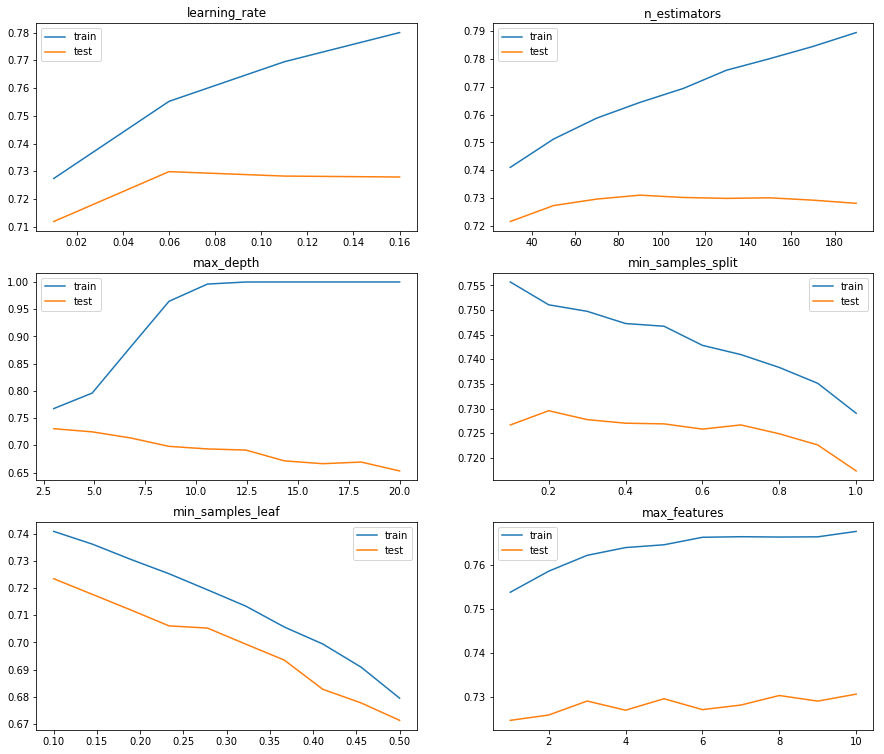

In [56]:
fig, axes = plt.subplots(3, 2)
fig.set_figheight(13)
fig.set_figwidth(15)

count = 0
for k in gb_result.keys():
    row = count // 2
    column = count % 2
    sns.lineplot(gb_result[k]["parameter"], gb_result[k]["train_result"], ax=axes[row, column], label="train")
    sns.lineplot(gb_result[k]["parameter"], gb_result[k]["test_result"], ax=axes[row, column], label="test")
    axes[row, column].set_title(k)
    count += 1

By looking at the diagram above, it can be seen that most of the default value for the model is quite optimal and further tuning the parameters will not improve the result too much. But, from the above diagram, we can also see that if we increase the **max_depth**, **min_samples_split** and **min_samples_leaf**, the performance of our model will drop and even causing **overfitting** (max_depth). 

So, we just use **GridSearch** to find the optimal value for the other three parameters.

In [57]:
# run with cautious (take long time)
gb_parameters = {
    "learning_rate": np.arange(0.01, 0.20, 0.05),
    "n_estimators": np.arange(30, 200, 20),
    "max_features": np.arange(1, len(tree_model_selected_features)+1)
}
_gb = GradientBoostingRegressor()
_gb_cv_clf = GridSearchCV(_gb, gb_parameters, cv=kf, scoring="roc_auc")
_gb_cv_clf.fit(X.loc[:, tree_model_selected_features], y)

GridSearchCV(cache_cv=True,
             cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=False),
             error_score='raise',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_sp...
                                                 presort='auto',
                                                 random_state=None,
                 

In [58]:
_gb_cv_clf.best_params_

{'learning_rate': 0.060000000000000005, 'max_features': 3, 'n_estimators': 170}

In [59]:
get_cv_score(_gb_cv_clf.best_estimator_, X.loc[:, tree_model_selected_features], y, kf)

0.7266807274042302

Look like the improvement is very slight. Then, we should focus more on ensembling the model instead of tuning the hyperparameters.

### Ensemble Models (Stacking)

In [60]:
from copy import deepcopy

In [61]:
class StackingRegressor:
    def __init__(self, models, second_model, features):
        self.models = models
        self.feature_models = []
        self.second_model = second_model
        self.features = features
    
    def _generate_f_features(self, X):
        f_features = np.zeros((X.shape[0], len(self.features) * len(self.models)))
        for num, features in enumerate(self.features * len(self.models)):
            model = self.feature_models[num]
            f_features[:, num] = model.predict(X.loc[:, features[1]])
        return f_features
    
    def fit(self, X, y):
        # generate multiple trained models with different features
        for model in self.models:
            for feature in self.features:
                model.fit(X.loc[:, feature[1]], y)
                self.feature_models.append(deepcopy(model))
        f_features = self._generate_f_features(X)
        self.second_model.fit(f_features, y)
    
    def predict(self, X):
        f_features = self._generate_f_features(X)
        return self.second_model.predict(f_features)

In [62]:
features = [
    ("manual_features", manual_selected_features),
    ("linear_features", linear_model_selected_features),
    ("tree_features", tree_model_selected_features),
#     ("man_lin_features", set(manual_selected_features + linear_model_selected_features)),
#     ("man_tree_features", set(manual_selected_features + tree_model_selected_features)),
#     ("lin_tree_features", set(linear_model_selected_features + tree_model_selected_features)),
#     ("combined_features", set(manual_selected_features + linear_model_selected_features + tree_model_selected_features))
]

In [63]:
get_cv_score(StackingRegressor([GradientBoostingRegressor(), LinearRegression()], XGBRegressor(), features), X, y, kf)

0.7801989510895551

The result from **stacking** the models is far better than tunning the hyperparameters. So, we will use stacking to create the final model that will be used to predict whether the driving trip is *safe* or *dangerous*.

## Visualize and Report the model's performance
In this section, we also answer the last question which is 
5. How can the model help to make better business decision? For example, should we be very strict about the prediction result of the model or we can tolerate with some mistakes in the prediction result?

In [64]:
import scikitplot as skplt

from sklearn.metrics import classification_report

In [65]:
sr = StackingRegressor([GradientBoostingRegressor(), LinearRegression()], XGBRegressor(), features)
sr.fit(train_X, train_y) # this was created in section 1.5.1
y_pred = sr.predict(test_X)

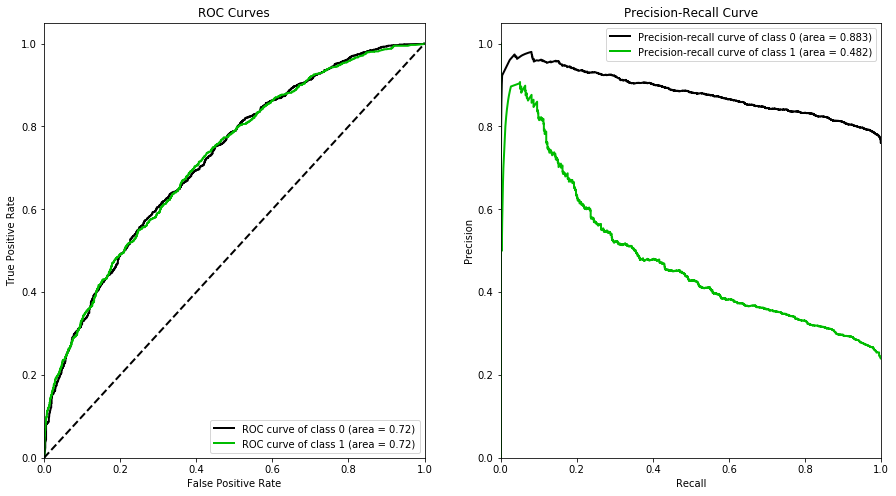

In [66]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
skplt.metrics.plot_roc(test_y, np.column_stack((1-y_pred, y_pred)), plot_macro=False, plot_micro=False, ax=axes[0])
skplt.metrics.plot_precision_recall(test_y, np.column_stack((1-y_pred, y_pred)), plot_micro=False, ax=axes[1])

By looking at the diagram above, we can decide what threshold that we want when separating the driving trip is *safe* or *dangerous*.

From **ROC Curves**, we can observe that the model have **good separability** for these 2 classes. Thus, we need to use this model to decide what threshold that we want to use in order to separate our predicted value into *dangerous* or *safe* driving trip.

The threshold will be mainly affected by the **business decision**. For instance, if we want our customers to have safe trips everytime, we need to filter out the drivers that are having *dangerous* trip a lot of time and provide them more trainings so that their number of *dangerous* driving trip will reduce. 

In this example, we need to have **high precision** since we want the model to help us in filtering out this small portion of *dangerous* driving trips. We do not want our model to wrongly accuse drivers who are driving safely. Thus, by looking at the **Precision-Recall Curve**, we can know that the threshold should be set around **0.8**. By setting the threshold in this value, we can sure that **most of the driving trips** that predicted to be *dangerous* are correct.

In [67]:
y_result = np.where(y_pred > 0.8, 1, 0)

In [68]:
print(classification_report(test_y, y_result))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      3040
           1       0.75      0.13      0.21       959

    accuracy                           0.78      3999
   macro avg       0.76      0.56      0.54      3999
weighted avg       0.77      0.78      0.71      3999



By looking at the report, we know that out of **100** driving trips that we predicted to be *dangerous*, there is **75** cases are correct.

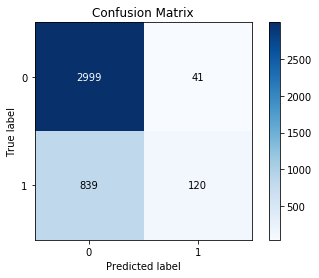

In [69]:
skplt.metrics.plot_confusion_matrix(test_y, y_result)

From the confusion matrix above, we can see that in this example, there is **161 (41+120)** driving trips are predicted to be *dangerous* and **120** driving trips predicted are correct. 

So, by combining result of these 2 curves, we can have an understanding about the performance of our model as well as deciding which threshold to separate our predicted value into *dangerous* or *safe* driving trip based on business decision.

## Save the model
save the model and use it to predict the data later. 
> Do run this section, just use the model provided.

In [70]:
# from joblib import dump

In [71]:
# sr = StackingRegressor([GradientBoostingRegressor(), LinearRegression()], XGBRegressor(), features)
# sr.fit(X, y)

In [72]:
# dump(sr, "./model/stackingRegressor.joblib")

['stackingRegressor.joblib']

## Run for Test Data
Just run cells in this section to get the result for the testing data.
> Note that it will only generate the predicted value

In [ ]:
import pandas as pd
import numpy as np

from joblib import load
from copy import deepcopy

In [ ]:
class StackingRegressor:
    def __init__(self, models, second_model, features):
        self.models = models
        self.feature_models = []
        self.second_model = second_model
        self.features = features
    
    def _generate_f_features(self, X):
        f_features = np.zeros((X.shape[0], len(self.features) * len(self.models)))
        for num, features in enumerate(self.features * len(self.models)):
            model = self.feature_models[num]
            f_features[:, num] = model.predict(X.loc[:, features[1]])
        return f_features
    
    def fit(self, X, y):
        # generate multiple trained models with different features
        for model in self.models:
            for feature in self.features:
                model.fit(X.loc[:, feature[1]], y)
                self.feature_models.append(deepcopy(model))
        f_features = self._generate_f_features(X)
        self.second_model.fit(f_features, y)
    
    def predict(self, X):
        f_features = self._generate_f_features(X)
        return self.second_model.predict(f_features)

In [ ]:
test_file = "" # add the csv filename for the testing data

In [ ]:
test_data = pd.read_csv(test_file)

In [ ]:
test_X = pd.DataFrame()
for col in test_data.columns:
    if col != "bookingID":
        temp = test_data.groupby("bookingID")[col].agg(["mean", "sum", "max", "min"])
        test_X[col + "_mean"] = temp["mean"]
        test_X[col + "_sum"] = temp["sum"]
        test_X[col + "_max"] = temp["max"]
        test_X[col + "_min"] = temp["min"]

In [ ]:
bookingID = test_X.index

In [ ]:
test_X = test_X.reset_index(drop=True)

In [ ]:
test_X.drop(columns=["second_min"], inplace=True)

In [ ]:
# generate distance, velocity and angle features
for col in test_X.columns:
    if col.startswith("second"):
        agg_method = col.split("_")[1]
        test_X["distance_" + agg_method] = test_X[col] * test_X["Speed_" + agg_method]
        test_X["velocity_x_" + agg_method] = test_X[col] * test_X["acceleration_x_" + agg_method]
        test_X["velocity_y_" + agg_method] = test_X[col] * test_X["acceleration_y_" + agg_method]
        test_X["velocity_z_" + agg_method] = test_X[col] * test_X["acceleration_z_" + agg_method]
        test_X["angle_x_" + agg_method] = test_X[col] * test_X["gyro_x_" + agg_method]
        test_X["angle_y_" + agg_method] = test_X[col] * test_X["gyro_y_" + agg_method]
        test_X["angle_z_" + agg_method] = test_X[col] * test_X["gyro_z_" + agg_method]

In [ ]:
sr = load("stackingRegressor.joblib")
y_pred = sr.predict(test_X)

In [ ]:
output_df = pd.DataFrame({"bookingID": bookingID, "label": y_pred})

In [ ]:
output_df.to_csv("submission.csv")